# Counting Clicks inside Action Units

### import packages

In [1]:
import re
import glob
import pickle
import json

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage import measure
import seaborn as sns
sns.set_context('talk')

from tqdm.notebook import tqdm

For Plotting

In [2]:
with open('../data/interim/im_dims.json', 'r') as fp:
    dim_dict = json.load(fp)

scale_factor = dim_dict['scale_factor']

with open('../references/my_settings.json', 'r') as fp:
    settings_dict = json.load(fp)

my_order = settings_dict['my_order']

with open('../models/palette.pkl', 'rb') as fp:
    color_palette = pickle.load(fp)

with open('../data/processed/stat_ims.json', 'rb') as fp:
    thresh_dict = pickle.load(fp)

### get stimuli

In [3]:
stim_df = pd.read_csv('../data/interim/stim_df.tsv', sep='\t', index_col=[0, 1, 2])

In [4]:
def load_im(file_name):
    
    img = cv2.imread(file_name,  cv2.IMREAD_GRAYSCALE)
    x_shape, y_shape = img.shape
    scale = 1
    new_shape = (int(y_shape*scale), int(x_shape*scale))
    res = cv2.resize(img, dsize=new_shape)
    
    return res

Example condition

In [5]:
im_key = ('Full','Fearful','AF01')

In [6]:
file_name = stim_df.loc[im_key, 'file_name']
res = load_im(file_name)

get prototypical image shape 

In [7]:
n_rows, n_cols = res.shape
n_rows, n_cols

(762, 562)

### get data

In [8]:
data_df = pd.read_csv('../data/interim/big_df.tsv', sep='\t', index_col=[0, 1], header=[0, 1, 2])
data_df.head(5)

Full  \
                                                       Fearful   
                                                          AF01   
p001 upper                                                   6   
     lower                                                   3   
     coords  [(333.0, 387.0), (379.0, 384.0), (246.0, 393.0...   
     diff                                                    3   
     Answer                                            Fearful   

                                                                \
                                                                 
                                                          AF05   
p001 upper                                                   8   
     lower                                                   2   
     coords  [(324.0, 392.0), (375.0, 390.0), (377.0, 357.0...   
     diff                                                    6   
     Answer                                              Angry   

                                                                \
                                                                 
                                                          AF07   
p001 upper                                                   4   
     lower                                                   6   
     coords  [(293.0, 511.0), (272.0, 587.0), (331.0, 488.0...   
     diff                                                   -2   
     Answer                                              Angry   

                                                                \
                                                                 
                                                          AF14   
p001 upper                                                   6   
     lower                                                   3   
     coords  [(311.0, 386.0), (386.0, 383.0), (236.0, 394.0...   
     diff                                                    3   
     Answer                                            Fearful   

                                                                \
                                                                 
                                                          AF30   
p001 upper                                                   4   
     lower                                                   4   
     coords  [(323.0, 545.0), (240.0, 552.0), (241.0, 472.0...   
     diff                                                    0   
     Answer                                                Sad   

                                                                \
                                                                 
                                                          AM02   
p001 upper                                                   5   
     lower                                                   4   
     coords  [(343.0, 548.0), (231.0, 540.0), (279.0, 465.0...   
     diff                                                    1   
     Answer                                          Surprised   

                                                                \
                                                                 
                                                          AM04   
p001 upper                                                   5   
     lower                                                   2   
     coords  [(324.0, 384.0), (381.0, 384.0), (244.0, 390.0...   
     diff                                                    3   
     Answer                                            Fearful   

                                                                \
                                                                 
                                                          AM06   
p001 upper                                                   6   
     lower                                                   3   
     coords  [(313.0, 394

### put coordinates into numpy array

In [9]:
def make_array(p_num, im_key, data_df, n_rows=n_rows, n_cols=n_cols):
    
    these_coords = eval(data_df.loc[(p_num,'coords'),im_key])

    zero_array = np.zeros((n_rows, n_cols))
    
    for (y,x) in these_coords:
        x, y = int(x), int(y)
        zero_array[(x,y)] = 1
    
    return zero_array

#### example participant

In [10]:
p_num = data_df.index.levels[0][1]
p_num

'p002'

In [11]:
data_df.columns.levels[2]

Index(['AF01', 'AF05', 'AF07', 'AF14', 'AF30', 'AM02', 'AM04', 'AM06', 'AM23',
       'AM32'],
      dtype='object')

In [12]:
im_key = ('Lower', 'Happy', 'AF30')

In [13]:
zero_array = make_array(p_num, im_key, data_df)

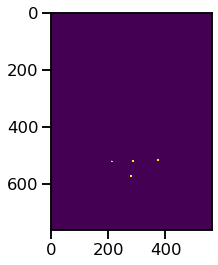

In [14]:
plt.imshow(zero_array,vmin=0,vmax=0.001);

### get all AUs

In [15]:
au_list = glob.glob('../references/AUs/**/*.png')

In [16]:
au_list

['../references/AUs/Ekel/Ekel-AU4.png',
 '../references/AUs/Ekel/Ekel-AU15+16.png',
 '../references/AUs/Ekel/Ekel-AU9+10.png',
 '../references/AUs/Angst/Angst-AU5+7.png',
 '../references/AUs/Angst/Angst-AU26.png',
 '../references/AUs/Angst/Angst-AU1+2+4.png',
 '../references/AUs/Angst/Angst-AU20.png',
 '../references/AUs/Überraschung/Überraschung-AU26.png',
 '../references/AUs/Überraschung/Überraschung-AU5.png',
 '../references/AUs/Überraschung/Überraschung-AU1+2.png',
 '../references/AUs/Ärger/Ärger-AU4.png',
 '../references/AUs/Ärger/Ärger-AU23.png',
 '../references/AUs/Ärger/Ärger-AU7(+5).png',
 '../references/AUs/Freude/Freude-AU12.png',
 '../references/AUs/Freude/Freude-AU6.png',
 '../references/AUs/Trauer/Trauer-AU15.png',
 '../references/AUs/Trauer/Trauer-AU1+4.png']

In [17]:
regex = re.compile(r'.*AUs/(\w+)/.*-(.*).png')

In [18]:
au_df = pd.DataFrame(au_list)
au_df.columns = ['file_name']
idx = [regex.findall(i)[-1] for i in au_df['file_name']]
au_df.index = pd.MultiIndex.from_tuples(idx)
au_df = au_df.sort_index()

In [19]:
rename_dict = {'Angst': 'Fearful',
               'Ärger': 'Angry',
               'Ekel': 'Disgusted',
               'Freude': 'Happy',
               'Neutral': 'Neutral',
               'Trauer': 'Sad',
               'Überraschung': 'Surprised'}

In [20]:
au_df = au_df.rename(rename_dict)

In [21]:
au_df

file_name
Fearful   AU1+2+4          ../references/AUs/Angst/Angst-AU1+2+4.png
          AU20                ../references/AUs/Angst/Angst-AU20.png
          AU26                ../references/AUs/Angst/Angst-AU26.png
          AU5+7              ../references/AUs/Angst/Angst-AU5+7.png
Disgusted AU15+16            ../references/AUs/Ekel/Ekel-AU15+16.png
          AU4                    ../references/AUs/Ekel/Ekel-AU4.png
          AU9+10              ../references/AUs/Ekel/Ekel-AU9+10.png
Happy     AU12              ../references/AUs/Freude/Freude-AU12.png
          AU6                ../references/AUs/Freude/Freude-AU6.png
Sad       AU1+4            ../references/AUs/Trauer/Trauer-AU1+4.png
          AU15              ../references/AUs/Trauer/Trauer-AU15.png
Angry     AU23                ../references/AUs/Ärger/Ärger-AU23.png
          AU4                  ../references/AUs/Ärger/Ärger-AU4.png
          AU7(+5)          ../references/AUs/Ärger/Ärger-AU7(+5).png
Surprised AU1+2    ../references/AUs/Überraschung/Überraschung-AU...
          AU26     ../references/AUs/Überraschung/Überraschung-AU...
          AU5      ../references/AUs/Überraschung/Überraschung-AU...

### show AUs

In [22]:
this_order = [i for i in my_order if i !='Neutral']

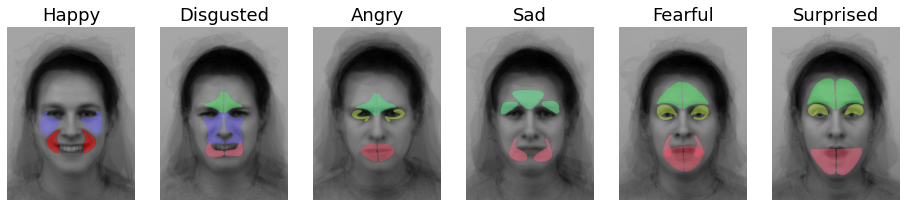

In [23]:
fig = plt.figure(figsize=(16, 6))

for n, i in enumerate(this_order):
    
    ax = plt.subplot(1, len(this_order), n+1)
    
    ims = stim_df.loc[('Full',i),'file_name'].values
    mean_im = np.mean([load_im(i) for i in ims],axis=0)
    ax.imshow(mean_im , cmap='Greys_r' )
    
    for au in au_df.loc[i].index:
        ax.imshow(plt.imread(au_df.loc[(i,au),'file_name']))
    
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(i)
    sns.despine(bottom=True, left=True, ax=ax)

plt.savefig('../reports/figures/au_drawings.png', bbox_inches='tight', dpi=300)
plt.show()

### show stat images with  AUs as contours

In [24]:
with open('../models/primary_palette.pkl', 'rb') as fp:
    cpal = pickle.load(fp)

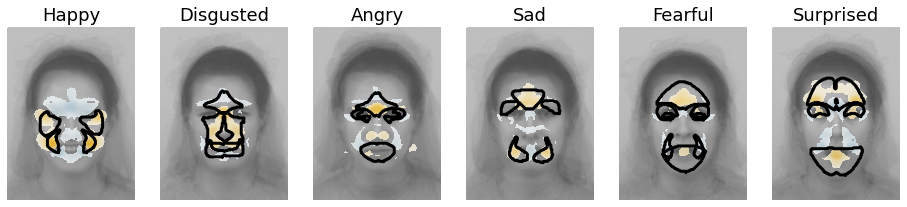

In [25]:
fig = plt.figure(figsize=(16, 6))

for n, i in enumerate(this_order):
    
    ax = plt.subplot(1, len(this_order), n+1)
    
    ims = stim_df.loc[('Full',i),'file_name'].values
    mean_im = np.mean([load_im(i) for i in ims],axis=0)
    ax.imshow(mean_im[::scale_factor, ::scale_factor] , cmap='Greys_r' , alpha=0.7)
    
    thresh_im = thresh_dict['Full']['clean'][f'{i}-{i}']
    ax.imshow(thresh_im, cmap=ListedColormap(color_palette), vmin=-1, vmax=1, alpha=0.8)

    for au in au_df.loc[i].index:
        au_im = plt.imread(au_df.loc[(i,au),'file_name'])[::scale_factor, ::scale_factor]
        #ax.imshow(au_im)
        
        mean_au_im = au_im.mean(axis=2)
        contours = measure.find_contours(abs(mean_au_im)>0, 0.9999)
        for contour in contours:
            plt.plot(contour[:, 1], contour[:, 0], linewidth=3, color=cpal[-2])

    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(i)
    sns.despine(bottom=True, left=True, ax=ax)

plt.savefig('../reports/figures/au_contours_with_results.png', bbox_inches='tight', dpi=300)

plt.show()

### compute AU size

In [26]:
emos = au_df.index.levels[0]

for n, i in enumerate(emos):

    for au in au_df.loc[i].index:
        im = plt.imread(au_df.loc[(i,au),'file_name'])
    break

In [27]:
flat_im = im.flatten()

In [28]:
npixels = flat_im.shape[0]

In [29]:
aupixels = (flat_im>0).sum()

In [30]:
aupixels/npixels

0.011563501181569385

In [31]:
(im.flatten()>0).sum()

19808

### for one AU

In [32]:
def make_au_array(zero_array, my_au, au_df=au_df):
    
    au_im = au_df.loc[my_au,'file_name']
    au = plt.imread(au_im, format='greyscale')
    au = au.max(axis=2)>0
    
    masked_array = zero_array * au
    
    return masked_array

In [33]:
masked_array = make_au_array(zero_array, ('Happy','AU12'))

In [34]:
count = masked_array.flatten().sum()
count

2.0

### for all AUs

In [35]:
def make_all_aus(zero_array, au_df=au_df):
    
    count_dict = {}
    
    count_dict[('Image','Image')] = zero_array.flatten().sum()
    
    for au in au_df.index:
        masked_array = make_au_array(zero_array, au)
        count_dict[au] = masked_array.flatten().sum()

    this_count_df = pd.DataFrame(count_dict, index=['counts'])
    
    return this_count_df

In [36]:
this_count_df = make_all_aus(zero_array)
this_count_df

Image Fearful                 Disgusted             Happy        Sad  \
       Image AU1+2+4 AU20 AU26 AU5+7   AU15+16  AU4 AU9+10  AU12  AU6 AU1+4   
counts   4.0     0.0  1.0  1.0   0.0       1.0  0.0    0.0   2.0  0.0   0.0   

            Angry              Surprised            
       AU15  AU23  AU4 AU7(+5)     AU1+2 AU26  AU5  
counts  1.0   2.0  0.0     0.0       0.0  1.0  0.0

### for all faces

In [37]:
def make_p_df(p_num, data_df, stim_df=stim_df):
    
    p_df = pd.DataFrame()
    
    for im_key in tqdm(stim_df.index, leave=False):

        zero_array = make_array(p_num, im_key, data_df)
        this_count_df = make_all_aus(zero_array)
        this_count_df.index = pd.MultiIndex.from_tuples([im_key])

        p_df = pd.concat([p_df, this_count_df])

    return p_df

In [38]:
p_df = make_p_df(p_num, data_df)

  0%|          | 0/210 [00:00<?, ?it/s]

### make all p

This may take multiple hours!

In [39]:
big_df = pd.DataFrame()

for p_num in tqdm(data_df.index.levels[0]):
    p_df = make_p_df(p_num, data_df)
    
    idx = [(p_num, i[0], i[1], i[2]) for i in p_df.index]
    p_df.index = pd.MultiIndex.from_tuples(idx)
    p_df = p_df.sort_index()
    
    big_df = pd.concat([big_df, p_df])

  0%|          | 0/202 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:49<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

In [40]:
big_df

Image Fearful                 Disgusted              \
                          Image AU1+2+4 AU20 AU26 AU5+7   AU15+16  AU4 AU9+10   
p001 Full  Angry     AF01   9.0     1.0  1.0  2.0   1.0       2.0  2.0    2.0   
                     AF05   9.0     0.0  1.0  2.0   5.0       2.0  0.0    1.0   
                     AF07   9.0     0.0  1.0  3.0   3.0       3.0  0.0    1.0   
                     AF14  10.0     0.0  1.0  2.0   6.0       2.0  0.0    1.0   
                     AF30  10.0     1.0  3.0  2.0   3.0       1.0  1.0    2.0   
...                         ...     ...  ...  ...   ...       ...  ...    ...   
p233 Upper Surprised AM02   4.0     1.0  0.0  0.0   0.0       0.0  0.0    0.0   
                     AM04   7.0     2.0  0.0  0.0   4.0       0.0  1.0    0.0   
                     AM06   5.0     1.0  0.0  0.0   3.0       0.0  0.0    0.0   
                     AM23   4.0     0.0  0.0  0.0   3.0       0.0  0.0    0.0   
                     AM32   4.0     2.0  0.0  0.0   1.0       0.0  2.0    0.0   

                          Happy        Sad      Angry              Surprised  \
                           AU12  AU6 AU1+4 AU15  AU23  AU4 AU7(+5)     AU1+2   
p001 Full  Angry     AF01   1.0  1.0   3.0  2.0   2.0  3.0     2.0       1.0   
                     AF05   0.0  2.0   2.0  2.0   2.0  1.0     2.0       0.0   
                     AF07   1.0  0.0   2.0  1.0   3.0  2.0     1.0       0.0   
                     AF14   0.0  0.0   3.0  2.0   2.0  3.0     2.0       0.0   
                     AF30   0.0  1.0   2.0  2.0   1.0  2.0     2.0       1.0   
...                         ...  ...   ...  ...   ...  ...     ...       ...   
p233 Upper Surprised AM02   0.0  0.0   2.0  0.0   0.0  0.0     0.0       1.0   
                     AM04   0.0  0.0   4.0  0.0   0.0  1.0     2.0       1.0   
                     AM06   0.0  1.0   1.0  0.0   0.0  0.0     2.0       1.0   
                     AM23   0.0  0.0   2.0  0.0   0.0  0.0     0.0       0.0   
                     AM32   0.0  0.0   2.0  0.0   0.0  2.0     0.0       2.0   

                                     
                          AU26  AU5  
p001 Full  Angry     AF01  2.0  3.0  
                     AF05  2.0  4.0  
                     AF07  3.0  3.0  
                     AF14  2.0  5.0  
                     AF30  2.0  3.0  
...                        ...  ...  
p233 Upper Surprised AM02  0.0  0.0  
                     AM04  0.0  6.0  
                     AM06  0.0  3.0  
                     AM23  0.0  3.0  
                     AM32  0.0  1.0  

[42420 rows x 18 columns]

### store

In [41]:
big_df.to_csv('../data/interim/big_au_df.tsv', sep='\t')

### re-load

In [42]:
big_df = pd.read_csv('../data/interim/big_au_df.tsv',
            sep='\t',
            index_col=[0, 1, 2, 3],
            header=[0, 1])

### store different levels of aggregation

In [43]:
big_p_df = big_df.groupby(level=[0,1,2]).mean()
big_p_df

Image Fearful                 Disgusted              \
                     Image AU1+2+4 AU20 AU26 AU5+7   AU15+16  AU4 AU9+10   
p001 Full  Angry       9.4     0.2  1.5  2.3   3.7       1.9  0.8    1.1   
           Disgusted   9.0     0.3  1.3  1.4   2.7       1.4  0.9    2.2   
           Fearful     9.1     1.3  1.0  1.5   2.8       1.4  1.8    2.0   
           Happy       7.7     0.2  1.2  0.6   2.0       1.2  0.6    1.8   
           Neutral     7.8     0.8  1.4  1.5   2.5       1.7  1.1    1.4   
...                    ...     ...  ...  ...   ...       ...  ...    ...   
p233 Upper Fearful     4.5     1.9  0.0  0.0   0.2       0.0  2.0    0.0   
           Happy       3.9     0.2  0.0  0.0   0.8       0.0  0.2    0.8   
           Neutral     4.4     0.9  0.0  0.0   1.4       0.0  1.0    0.0   
           Sad         5.0     2.0  0.0  0.0   1.1       0.0  2.4    0.0   
           Surprised   4.5     1.5  0.0  0.0   1.3       0.0  0.7    0.0   

                     Happy        Sad      Angry              Surprised       \
                      AU12  AU6 AU1+4 AU15  AU23  AU4 AU7(+5)     AU1+2 AU26   
p001 Full  Angry       0.6  0.8   2.4  1.7   2.2  1.9     1.8       0.2  2.1   
           Disgusted   1.5  0.6   1.0  0.9   2.3  1.4     1.5       0.4  1.0   
           Fearful     0.4  1.1   2.4  1.2   1.7  1.8     2.2       1.3  1.6   
           Happy       2.5  1.5   1.0  1.2   0.9  0.7     1.7       0.3  0.6   
           Neutral     0.9  0.9   1.6  1.0   1.5  1.4     1.7       0.5  1.2   
...                    ...  ...   ...  ...   ...  ...     ...       ...  ...   
p233 Upper Fearful     0.0  0.3   1.9  0.0   0.0  2.0     0.4       1.9  0.0   
           Happy       0.0  2.7   0.3  0.0   0.0  0.2     0.5       0.2  0.0   
           Neutral     0.0  0.5   1.4  0.0   0.0  1.1     0.7       0.7  0.0   
           Sad         0.0  0.1   2.7  0.0   0.0  2.3     0.4       2.2  0.0   
           Surprised   0.0  0.3   1.8  0.0   0.0  0.7     0.8       1.2  0.0   

                           
                      AU5  
p001 Full  Angry      3.8  
           Disgusted  2.7  
           Fearful    2.2  
           Happy      1.5  
           Neutral    2.7  
...                   ...  
p233 Upper Fearful    0.3  
           Happy      0.4  
           Neutral    2.0  
           Sad        1.6  
           Surprised  1.8  

[4242 rows x 18 columns]

In [44]:
big_p_df.to_csv('../data/processed/big_p_au_df.tsv', sep='\t')

### sanity checks

The number of clicks in the whole image extracted by the current notebook's methods should equal the conventional way click counts were extracted in the previous notebooks

#### data from previous notebook

In [45]:
count_df = pd.read_csv('../data/interim/big_df.tsv', sep='\t',index_col=[0,1], header=[0,1,2])

In [46]:
count_df

Full  \
                                                       Fearful   
                                                          AF01   
p001 upper                                                   6   
     lower                                                   3   
     coords  [(333.0, 387.0), (379.0, 384.0), (246.0, 393.0...   
     diff                                                    3   
     Answer                                            Fearful   
...                                                        ...   
p233 upper                                                   2   
     lower                                                   4   
     coords  [(350.0, 389.0), (213.0, 385.0), (270.0, 554.0...   
     diff                                                   -2   
     Answer                                          Surprised   

                                                                \
                                                                 
                                                          AF05   
p001 upper                                                   8   
     lower                                                   2   
     coords  [(324.0, 392.0), (375.0, 390.0), (377.0, 357.0...   
     diff                                                    6   
     Answer                                              Angry   
...                                                        ...   
p233 upper                                                   3   
     lower                                                   0   
     coords   [(276.0, 352.0), (195.0, 391.0), (365.0, 391.0)]   
     diff                                                    3   
     Answer                                          Surprised   

                                                                \
                                                                 
                                                          AF07   
p001 upper                                                   4   
     lower                                                   6   
     coords  [(293.0, 511.0), (272.0, 587.0), (331.0, 488.0...   
     diff                                                   -2   
     Answer                                              Angry   
...                                                        ...   
p233 upper                                                   2   
     lower                                                   2   
     coords  [(328.0, 538.0), (234.0, 544.0), (357.0, 384.0...   
     diff                                                    0   
     Answer                                          Surprised   

                                                                \
                                                                 
                                                          AF14   
p001 upper                                                   6   
     lower                                                   3   
     coords  [(311.0, 386.0), (386.0, 383.0), (236.0, 394.0...   
     diff                                                    3   
     Answer                                            Fearful   
...                                                        ...   
p233 upper                                                   4   
     lower                                                   1   
     coords  [(278.0, 551.0), (264.0, 330.0), (313.0, 332.0...   
     diff                                                    3   
     Answer                                            Fearful   

                                                                \
                                                                 
                                                          AF30   
p001 upper                                                   4   
     lower                                                   4   
     coords  [(323.0, 545.0)

In [47]:
clean_count_df = count_df.unstack(1).stack([0,1,2])
clean_count_df = clean_count_df.loc[:, ['upper', 'lower']]
clean_count_df = clean_count_df.astype(int)
clean_count_df.loc[:, 'sum'] = clean_count_df.loc[:, 'lower'] + clean_count_df.loc[:, 'upper']
clean_count_df = clean_count_df.drop(['upper', 'lower'], axis=1)
clean_count_df.columns = ['count']

In [48]:
clean_count_df.tail()

count
p233 Upper Surprised AM02      4
                     AM04      7
                     AM06      5
                     AM23      4
                     AM32      4

#### data from this notebook

In [49]:
current_df = big_df.loc[:, 'Image']
current_df.columns = ['count']

In [50]:
current_df.tail()

count
p233 Upper Surprised AM02    4.0
                     AM04    7.0
                     AM06    5.0
                     AM23    4.0
                     AM32    4.0

#### test for identical values

In [51]:
assert (current_df == clean_count_df).all()['count'], 'the two methods give different results!'